In [1]:
import os
project_dir = "c:/Users/sqin34/OneDrive - UW-Madison/Research/solvgnn/"
os.chdir(project_dir)

In [2]:
import pickle
import torch
from solvgnn.model.model_GNN import solvgnn_binary, get_n_params
from solvgnn.util.generate_dataset import solvent_dataset_binary
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

Using backend: pytorch


In [3]:
saved_model_dir = project_dir + "results/job_220812_solvgnn_binary_with_inf_catx/"

Summary statistics

In [4]:
valid_ind_list = np.load(saved_model_dir + 'saved_model/valid_ind_list.npy')
valid_loss_list = []
for cv_id in range(5):
    valid_loss_list.append(np.load(saved_model_dir + 'saved_model/val_loss_cv{}.npy'.format(cv_id))[-1])
print("mean CV MSE loss {:.4f}, std CV MSE loss {:.4f}".format(np.mean(valid_loss_list), np.std(valid_loss_list)))
best_cv_id = np.argmin(valid_loss_list)
print("best CV fold: {}".format(best_cv_id))

mean CV MSE loss 0.0088, std CV MSE loss 0.0030
best CV fold: 4


Load data class

In [5]:
dataset_path = project_dir + "solvgnn/data/output_binary_with_inf_all.csv"
solvent_list_path = project_dir + 'solvgnn/data/solvent_list.csv'
dataset = solvent_dataset_binary(
    input_file_path=dataset_path,
    solvent_list_path = solvent_list_path,
    generate_all=True)

c:\Users\sqin34\miniconda3\envs\solvgnn\lib\site-packages\ipykernel_launcher.py:6: DtypeWarning: Columns (10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  


Check for permutation invariance

In [6]:
cv_id = 0
valid_ind = valid_ind_list[cv_id]
empty_solvsys = dataset.generate_solvsys(batch_size=1)
model = solvgnn_binary(in_dim=74, hidden_dim=256, n_classes=1).cuda()
checkpoint = torch.load(saved_model_dir + 'saved_model/final_model_cv{}.pth'.format(cv_id))
print("# model params: {}".format(get_n_params(model)))
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# model params: 2840641


solvgnn_binary(
  (conv1): GraphConv(in=74, out=256, normalization=both, activation=None)
  (conv2): GraphConv(in=256, out=256, normalization=both, activation=None)
  (global_conv1): MPNNconv(
    (project_node_feats): Sequential(
      (0): Linear(in_features=257, out_features=256, bias=True)
      (1): ReLU()
    )
    (gnn_layer): NNConv(
      (edge_nn): Sequential(
        (0): Linear(in_features=1, out_features=32, bias=True)
        (1): ReLU()
        (2): Linear(in_features=32, out_features=65536, bias=True)
      )
    )
    (gru): GRU(256, 256)
  )
  (classify1): Linear(in_features=256, out_features=256, bias=True)
  (classify2): Linear(in_features=256, out_features=256, bias=True)
  (classify3): Linear(in_features=256, out_features=1, bias=True)
)

In [7]:
chemical_list = ["alcohol", "water"]
smiles_list = ["CCCO", "O"]
solv1_x = 0.9
pred = dataset.predict_new(model,chemical_list,smiles_list,solv1_x,gamma_list=None)
print(pred)

[0.00680073 0.9467025 ]


In [9]:
chemical_list = ["water", "alcohol"]
smiles_list = ["O", "CCCO"]
solv1_x = 0.1
pred = dataset.predict_new(model,chemical_list,smiles_list,solv1_x,gamma_list=None)
print(pred)

[0.9467026  0.00680073]


Inference individual CV samples and save for further analysis

In [10]:
idx_all = []
true_gam1_all, true_gam2_all = [], []
pred_gam1_all, pred_gam2_all = [], []
intra_hb1_all, intra_hb2_all = [], []
inter_hb_all = []
solv1_x_all = []

In [11]:
for cv_id in range(5):
    print('Analayzing CV {}'.format(cv_id+1))
    valid_ind = valid_ind_list[cv_id]
    empty_solvsys = dataset.generate_solvsys(batch_size=1)
    model = solvgnn_binary(in_dim=74, hidden_dim=256, n_classes=1).cuda()
    checkpoint = torch.load(saved_model_dir + 'saved_model/final_model_cv{}.pth'.format(cv_id))
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    for count,idx in enumerate(valid_ind):
        idx_all.append(idx)
        solv1_x_all.append(dataset[idx]['solv1_x'])
        intra_hb1_all.append(dataset[idx]['intra_hb1'])
        intra_hb2_all.append(dataset[idx]['intra_hb2'])
        inter_hb_all.append(dataset[idx]['inter_hb'])
        true,pred = dataset.predict(idx,model,empty_solvsys)
        pred_gam1_all.append(pred[0])
        pred_gam2_all.append(pred[1])
        true_gam1_all.append(true[0])
        true_gam2_all.append(true[1])
        if (count+1) % 500 == 0:
            print('{} out of {} done!'.format(count+1,len(valid_ind)))

Analayzing CV 1
500 out of 56000 done!
1000 out of 56000 done!
1500 out of 56000 done!
2000 out of 56000 done!
2500 out of 56000 done!
3000 out of 56000 done!
3500 out of 56000 done!
4000 out of 56000 done!
4500 out of 56000 done!
5000 out of 56000 done!
5500 out of 56000 done!
6000 out of 56000 done!
6500 out of 56000 done!
7000 out of 56000 done!
7500 out of 56000 done!
8000 out of 56000 done!
8500 out of 56000 done!
9000 out of 56000 done!
9500 out of 56000 done!
10000 out of 56000 done!
10500 out of 56000 done!
11000 out of 56000 done!
11500 out of 56000 done!
12000 out of 56000 done!
12500 out of 56000 done!
13000 out of 56000 done!
13500 out of 56000 done!
14000 out of 56000 done!
14500 out of 56000 done!
15000 out of 56000 done!
15500 out of 56000 done!
16000 out of 56000 done!
16500 out of 56000 done!
17000 out of 56000 done!
17500 out of 56000 done!
18000 out of 56000 done!
18500 out of 56000 done!
19000 out of 56000 done!
19500 out of 56000 done!
20000 out of 56000 done!
2050

In [12]:
output_cv = pd.DataFrame({'idx':np.array(idx_all),
                          'true_gam1':np.array(true_gam1_all),
                          'pred_gam1':np.array(pred_gam1_all),
                          'true_gam2':np.array(true_gam2_all),
                          'pred_gam2':np.array(pred_gam2_all),
                          'solv1_x':np.array(solv1_x_all),
                          'intra_hb1':np.array(intra_hb1_all),
                          'intra_hb2':np.array(intra_hb2_all),
                          'inter_hb':np.array(inter_hb_all)                 
                          })

In [13]:
output_cv = output_cv.sort_values(by="idx").reset_index(drop=True)
raw_data = pd.read_csv(dataset_path)
raw_data = raw_data.rename(columns={"solv1_x": "solv1_x_input"})
output_cv = pd.concat([raw_data, output_cv], axis=1)
output_cv.to_csv(saved_model_dir + 'analysis/output_cv.csv',index=False)

c:\Users\sqin34\miniconda3\envs\solvgnn\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams.update({
    'text.usetex': True,
    'font.family':'serif',
    'font.serif':['Computer Modern'],
    'axes.labelsize':10,
    'xtick.labelsize':9,
    'ytick.labelsize':9})

c:\Users\sqin34\miniconda3\envs\solvgnn\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


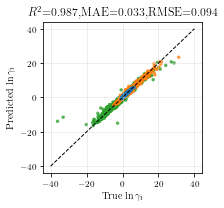

In [6]:
xmin = -40
xmax = 40
color_list = matplotlib.cm.get_cmap('tab10')
labels = ["nonpolar-nonpolar","polar-nonpolar","polar-polar"]
output_cv = pd.read_csv(saved_model_dir + 'analysis/output_cv.csv')
output_cv = pd.concat(
    (
        output_cv[["true_gam1", "pred_gam1", "tpsa_binary_avg"]]
        .rename(columns={
            "true_gam1": "true_gam",
            "pred_gam1": "pred_gam"}),
        output_cv[["true_gam2", "pred_gam2", "tpsa_binary_avg"]]
        .rename(columns={
            "true_gam2": "true_gam",
            "pred_gam2": "pred_gam"})
    ))
output_cv = output_cv.sort_values(by="tpsa_binary_avg",ascending=False)
fig,ax = plt.subplots(figsize=(3,3))
ax.grid(color='lightgray',linewidth=0.75,alpha=0.5)
ax.plot([xmin, xmax], 
           [xmin, xmax], color='black',linestyle='--', lw=1)
ax.scatter(output_cv['true_gam'],output_cv['pred_gam'],c=color_list(output_cv['tpsa_binary_avg']),s=6,alpha=0.7)
# ax.set_xticks(np.arange(-30, 20, 10))
ax.set_xlabel('True $\ln\gamma_i$')
ax.set_ylabel('Predicted $\ln\gamma_i$')
ax.set_title('$R^2$={:.3f},MAE={:.3f},RMSE={:.3f}'.format(r2_score(output_cv['true_gam'],output_cv['pred_gam']),
                                                  mean_absolute_error(output_cv['true_gam'],output_cv['pred_gam']),
                                                  np.sqrt(mean_squared_error(output_cv['true_gam'],output_cv['pred_gam']))))

# ax[1].grid(color='lightgray',linewidth=0.75,alpha=0.5)
# ax[1].plot([xmin, xmax], 
#            [xmin, xmax], color='black',linestyle='--', lw=1)
# ax[1].scatter(output_cv['true_gam2'],output_cv['pred_gam2'],c=color_list(output_cv['tpsa_binary_avg']),s=6,alpha=0.7)
# ax[1].set_xlabel('True $\ln\gamma_2$')
# ax[1].set_ylabel('Predicted $\ln\gamma_2$')

# ax[1].set_title('$R^2$={:.2f},MAE={:.3f},RMSE={:.3f}'.format(r2_score(output_cv['true_gam2'],output_cv['pred_gam2']),
#                                                   mean_absolute_error(output_cv['true_gam2'],output_cv['pred_gam2']),
#                                                   np.sqrt(mean_squared_error(output_cv['true_gam2'],output_cv['pred_gam2']))))
plt.tight_layout()
# plt.savefig(saved_model_dir + 'analysis/cv_parity.png',pad_inches=0,dpi=400,transparent=True)   

In [15]:
output_cv = pd.read_csv(saved_model_dir + 'analysis/output_cv.csv')
outlier = output_cv[output_cv.solv1_gamma < -30]

c:\Users\sqin34\miniconda3\envs\solvgnn\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [16]:
outlier

,job_id,solv1,solv2,solv1_x_input,solv2_x,solv1_gamma,solv2_gamma,warnings,solv1_smiles,solv2_smiles,...,tpsa_binary_avg,idx,true_gam1,pred_gam1,true_gam2,pred_gam2,solv1_x,intra_hb1,intra_hb2,inter_hb
11907,11907,solvent_394,solvent_540,0.1,0.9,-33.036728,-0.176247,NaN,NCCNCCN,C#N,...,2,11907,-33.036728,-11.508058,-0.176247,-2.541860,0.1,3,0,1
211907,11907,solvent_394,solvent_540,0.0,1.0,-36.172963,0.000000,NaN,NCCNCCN,C#N,...,2,211907,-36.172963,-13.889904,0.000000,-1.375951,0.0,3,0,1


In [17]:
outlier.iloc[0]

job_id                          11907
solv1                     solvent_394
solv2                     solvent_540
solv1_x_input                     0.1
solv2_x                           0.9
solv1_gamma                -33.036728
solv2_gamma                 -0.176247
warnings                          NaN
solv1_smiles                  NCCNCCN
solv2_smiles                      C#N
solv1_name         DIETHYLENETRIAMINE
solv2_name           HYDROGEN CYANIDE
tpsa_binary_avg                     2
idx                             11907
true_gam1                  -33.036728
pred_gam1                  -11.508058
true_gam2                   -0.176247
pred_gam2                    -2.54186
solv1_x                           0.1
intra_hb1                           3
intra_hb2                           0
inter_hb                            1
Name: 11907, dtype: object

In [18]:
outlier.iloc[1]

job_id                          11907
solv1                     solvent_394
solv2                     solvent_540
solv1_x_input                     0.0
solv2_x                           1.0
solv1_gamma                -36.172963
solv2_gamma                       0.0
warnings                          NaN
solv1_smiles                  NCCNCCN
solv2_smiles                      C#N
solv1_name         DIETHYLENETRIAMINE
solv2_name           HYDROGEN CYANIDE
tpsa_binary_avg                     2
idx                            211907
true_gam1                  -36.172963
pred_gam1                  -13.889904
true_gam2                         0.0
pred_gam2                   -1.375951
solv1_x                           0.0
intra_hb1                           3
intra_hb2                           0
inter_hb                            1
Name: 211907, dtype: object